While the 1D Ising model does not yet feature a phase transition, the 2D Ising model already does. This can be seen e.g. in the analytical result for the absolute magnetisation per particle for $H = 0$. where $T_{c}$ is the Curie temperature at which the phase transition occurs.
Implement a 2D Ising model on a square lattice with $n = \sqrt{N} = 20$ spins per side, again using periodic boundary conditions, $s_{n+1,j} = s_{1,j}$ and $s{i,n+1} = s{i,1}$, connecting sides with each other. Calculate the absolute magnetisation of the model for $H = 0$ in dependence of the thermal energy $k_{B}T$ with the same techniques used for the 1D model. Note that more time might be needed to reach equilibrium. Discuss your results. Can you reproduce the predicted phase transition?1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
seeds = np.load("seeds_3000x100.npy")

In [2]:
#generating 100 lists 3000 seeds
#seeds = []
#for i in range(100):
#    seeds_i = np.random.randint(0, 100000, size=3000)
#    seeds.append(seeds_i)
#seeds = np.array(seeds)
#np.save("seeds_3000x100", seeds)

In [3]:
def padding(a):
    bottom_row = np.array([a[-1]])
    top_row = np.array([a[0]])
    top_row_padded = np.concatenate((np.array([[0]]), top_row, np.array([[0]])), axis=1)
    bottom_row_padded = np.concatenate((np.array([[0]]), bottom_row, np.array([[0]])), axis=1)
    right_column = np.transpose([a[:,-1]])
    left_column = np.transpose([a[:,0]])
    a_cols = np.concatenate((right_column, a, left_column), axis=1)
    a_padded = np.concatenate((bottom_row_padded, a_cols, top_row_padded))
    return a_padded

def energy_2D(config, H_external=0, J=1):
    H = 0
    config_with_boundaries = padding(config)
    for i in range(1, config.shape[0]+1):
        for j in range(1, config.shape[1]+1):
            H_ij = config_with_boundaries[i][j]*(config_with_boundaries[i][j+1]+config_with_boundaries[i][j-1]+config_with_boundaries[i-1][j]+config_with_boundaries[i+1][j])
            H += H_ij
    H_ext = H_external * np.sum(config)
    return -(0.5*J*H+H_ext)

def metropolis_algorithm(initial_state, num_trials, beta, H_external=0, list_seeds=None):
    sequence_states = [initial_state]
    for n in range(num_trials):
        try:
            sd = list_seeds[n]
        except:
            sd = np.random.randint(100000)
        next_sequence = metropolis_step(sequence_states[-1], beta, H_external, seed = 5)
        sequence_states.append(next_sequence)
    return np.array(sequence_states), np.arange(num_trials+1)

def metropolis_step(current_state, beta, H_external, seed = None):
    #np.random.seed(seed)
    spin_flip_index = np.random.randint(0,current_state.shape[0], size=2)
    trial_configuration = copy.deepcopy(current_state)
    trial_configuration[spin_flip_index[0]][spin_flip_index[1]] *= -1
    energy_diff = energy_2D(trial_configuration, H_external) - energy_2D(current_state, H_external)
    trial_acceptance_prob = np.min([np.exp(-beta * energy_diff),1])
    r_accept = np.random.rand()
    if r_accept < trial_acceptance_prob:
        new_state = trial_configuration
    else:
        new_state = current_state
    return np.array(new_state)

def magnetisation(config):
    return np.sum(config)

def magnetisation_theor(beta, J=1):
    kT_c = 2.269185
    if 1/beta > kT_c:
        return 0
    else:
        z = np.exp(-2*J*beta)
        m_enum_1 = (1+z**2)**(1/4)
        m_enum_2 = (1-6*z**2 +z**4)**(1/8)
        m_denom = np.sqrt(1-z**2)
        return m_enum_1*m_enum_2/m_denom

In [15]:
N = 30
np.random.seed(42)
X_0 = np.random.choice([-1, 1], size=(N, N))
list_beta = np.array([50,40,30,20, 1.e+01, 1.e+00, 1/2.269186, 1/6 ,0.1])
list_M = []

for b in list_beta:
    tnow = datetime.datetime.now()
    formatted_time = tnow.strftime("%H:%M:%S")
    print(f"Metropolis algorithm for k_B T = {1/b} starting at {formatted_time}")
    list_M_beta = []
    for i in range(1):
        states_m, _ = metropolis_algorithm(initial_state=X_0, num_trials=100000, beta=b)
        states_m = states_m[-100:,:] #Keep only the equilibrium states
        mag_m = [magnetisation(state) for state in states_m]
        list_M_beta.append(mag_m)
    M_mean = np.mean(list_M_beta)
    list_M.append(M_mean)
    print(f"Mean magnetisation for k_B T = {1/b}: M = {M_mean}")

Metropolis algorithm for k_B T = 0.02 starting at 20:30:06
Mean magnetisation for k_B T = 0.02: M = 642.38
Metropolis algorithm for k_B T = 0.025 starting at 20:34:41
Mean magnetisation for k_B T = 0.025: M = 900.0
Metropolis algorithm for k_B T = 0.03333333333333333 starting at 20:39:13
Mean magnetisation for k_B T = 0.03333333333333333: M = 653.86
Metropolis algorithm for k_B T = 0.05 starting at 20:43:45
Mean magnetisation for k_B T = 0.05: M = 14.0
Metropolis algorithm for k_B T = 0.1 starting at 20:48:06
Mean magnetisation for k_B T = 0.1: M = 783.44
Metropolis algorithm for k_B T = 1.0 starting at 20:52:23
Mean magnetisation for k_B T = 1.0: M = 900.0
Metropolis algorithm for k_B T = 2.269186 starting at 20:56:35
Mean magnetisation for k_B T = 2.269186: M = 36.62
Metropolis algorithm for k_B T = 6.0 starting at 21:00:46
Mean magnetisation for k_B T = 6.0: M = 6.6
Metropolis algorithm for k_B T = 10.0 starting at 21:04:55
Mean magnetisation for k_B T = 10.0: M = 12.58


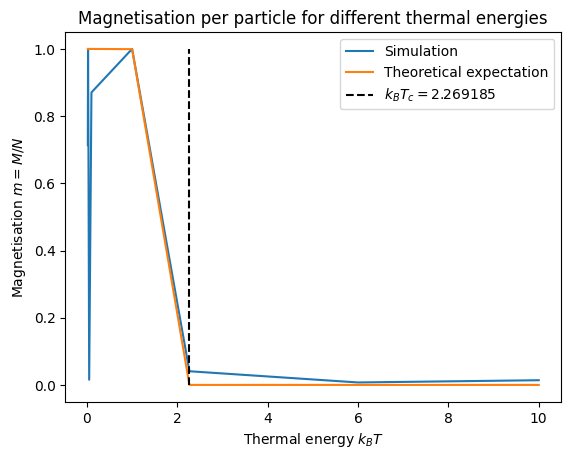

In [16]:
plt.plot(1/list_beta, np.array(list_M)/(N*N), label = "Simulation")
plt.plot(1/list_beta, [magnetisation_theor(b) for b in list_beta], label = f"Theoretical expectation")
plt.vlines(2.269185, 0, 1, "k", linestyles="dashed", label="$k_{B}T_{c}=2.269185$")
plt.title("Magnetisation per particle for different thermal energies")
plt.xlabel("Thermal energy $k_{B}T$")
plt.ylabel("Magnetisation $m = M/N$")
plt.legend()

We see that the simulation fits the analytical expectation relatively well, except for one extreme outlier. This may be because of a disadvantageous seed and the initial state with randomly arranged spins. Due to the long calculation time for the evaluations (many time steps needed), it was not possible to repeat the simulation for as many times per temperature than for the 1D Ising. Below we see the same plot with the eliminated outlier.

Generally, the simulation worked better for higher temperatures, as the initial state is chosen to be with random spin direction and therefore the system is more or less in the equilibrium state at the beginning of the simulation. As temperatures get lower, we have outliers, because the simulation did not get into the cold state even after 100000 time steps.

To summarize, the phase transition at $k_{B}T_{c}$ is reproduced by the simulation, but the performance of the simulation in the low temperature region is not stable.

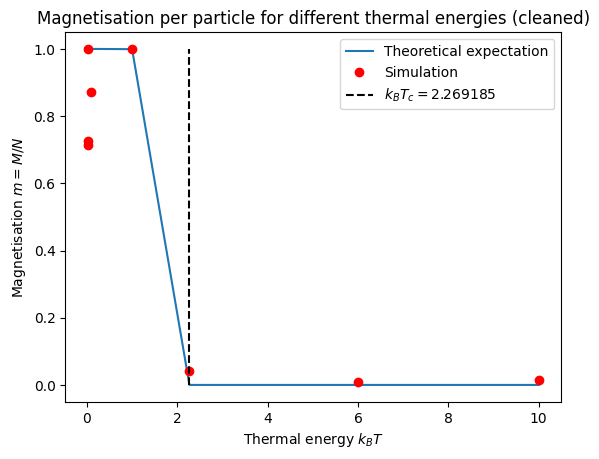

In [9]:
list_M_cleaned = [642.38 , 900.0, 653.86, 783.44 ,900.0, 36.62, 6.6, 12.58]
list_beta_cleaned = np.array([50,40,30, 1.e+01, 1.e+00, 1/2.269186, 1/6 ,0.1])
plt.plot(1/list_beta_cleaned, [magnetisation_theor(b) for b in list_beta_cleaned], label = f"Theoretical expectation")
plt.plot(1/list_beta_cleaned, np.array(list_M_cleaned)/(900), "ro", label = "Simulation")
plt.vlines(2.269185, 0, 1, "k", linestyles="dashed", label="$k_{B}T_{c}=2.269185$")
plt.title("Magnetisation per particle for different thermal energies (cleaned)")
plt.xlabel("Thermal energy $k_{B}T$")
plt.ylabel("Magnetisation $m = M/N$")
plt.legend()

In [4]:
def build_fcc():
    """
    :param M: integer. cube root of Number of unit cells
    :return: fcc grid for the L*L cube (np.array of shape (n_points, 3))
    """
    range_values_sc = np.linspace(-1/2, 1/2, 6+1)
    length_edge = np.abs(range_values_sc[0]-range_values_sc[1]) #L/(rho-1)
    sc_grid = np.array(list(product(range_values_sc, repeat=3)))
    sc_grid = sc_grid[sc_grid[:, 0] != -1/2]
    sc_grid = sc_grid[sc_grid[:, 1] != -1/2]
    sc_grid = sc_grid[sc_grid[:, 2] != -1/2]
    missing_points = []
    for point in sc_grid:
        p1 = [point[0]+0.5*length_edge, point[1], point[2]+0.5*length_edge]
        p2 = [point[0]+0.5*length_edge, point[1]+0.5*length_edge, point[2]]
        p3 = [point[0], point[1]+0.5*length_edge, point[2]+0.5*length_edge]
        missing_points.append(p1)
        missing_points.append(p2)
        missing_points.append(p3)
    missing_points = np.array(missing_points)
    x = sc_grid[:,0]
    y = sc_grid[:,1]
    z = sc_grid[:,2]
    x_m = missing_points[:,0]
    y_m = missing_points[:,1]
    z_m = missing_points[:,2]
    fcc_grid = np.concatenate([sc_grid, missing_points])

    return fcc_grid

build_fcc()
print(build_fcc().shape)

(864, 3)
